<a href="https://colab.research.google.com/github/Rogerio-mack/fNIRS/blob/main/MB04_change_snirf_for_selected_subjects_and_channels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install & import `nilearn` and `mne-nirs`

In [44]:
#@markdown
!pip install nilearn
!pip install -U --no-deps https://github.com/mne-tools/mne-python/archive/main.zip
!pip install mne-nirs

from mne.io import read_raw_nirx
from mne.preprocessing.nirs import (optical_density, beer_lambert_law,
                                    temporal_derivative_distribution_repair)
import mne 



  Using cached https://github.com/mne-tools/mne-python/archive/main.zip


## Mount Google Drive

In [45]:
#@markdown
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Common Imports

In [46]:
#@markdown 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib inline
import seaborn as sns

import h5py
from itertools import compress
from sklearn.preprocessing import scale
from google.colab import widgets

## Routines

In [47]:
#@markdown `def clone_snirf(path_in, path_out, fname='out.snirf')`
def clone_snirf(path_in, path_out, fname='out.snirf'):
  
  if path_in == path_out:
    print('Error: path_in and path_out can not be the same.') 
    return

  if not os.path.exists(path_out):
      os.mkdir(path_out)
      print("Directory " , path_out ,  "was created")
  else:    
      print("Warning: directory " , path_out ,  " already exists")

  if os.path.exists(path_out + fname):
    os.remove(path_out + fname)
    print('Warning: previous output file was deleted.')
  
  print('Input snirf file: ' + path_in + fname)

  fs = h5py.File(path_in + fname,'r')
  fd = h5py.File(path_out + fname,'w')

  if list(fs.keys()).count('formatVersion') >= 1:
    fs.copy('formatVersion',fd,'formatVersion') 
  else:
    print('Warning: there is no formatVersion key in snirf input.')

  if list(fs.keys()).count('nirs') >= 1:
    fs.copy('nirs',fd,'nirs') 
  else:
    print('Error: Invalid snirf file. There is no nirs key in snirf input.')  
  
  print('Output snirf file: ' + path_out + fname)
  
  fd.close()
  fs.close()

  return

In [48]:
#@markdown `def create_channels_table(data,reorder=False)`
def create_channels_table(data,reorder=False):

  if reorder:
    print('Warning: reorder=True puts channels names in ascendent order, but this can be a different order from snirf file.')

  # Parameters: 
  # data: snirf file read

  # create alias for all data['nirs'].keys()
  for key in data['nirs'].keys():
    exp = key + ' = data["nirs"]["' + key + '"] '
    print(exp)
    exec(exp)
    
  nr_measurements = len([ x for x in list( data1.keys() ) if 'measurementList' in x ])+1
  measurements = ['measurementList' + str(x) for x in np.arange(1,nr_measurements)] 
  # print(measurements)

  measure_idx = []
  name = []
  source =  []
  detector = []
  source_pos = []
  detector_pos = []
  source_pos_3D = []
  detector_pos_3D = []
  flag_2D = True
  flag_3D = True
  frequencies = []

  for m in measurements:
    measure_idx.append( int( m[ len('measurementList'):: ] ) )
    
    e_name = probe['sourceLabels'][ int(data1[m]['sourceIndex'][0]) - 1 ].decode('UTF-8') + '_' + probe['detectorLabels'][ int(data1[m]['detectorIndex'][0]) - 1 ].decode('UTF-8') 
    e_source = int(data1[m]['sourceIndex'][0])   
    e_detector = int(data1[m]['detectorIndex'][0]) 
    
    if list(probe.keys()).count('sourcePos2D') > 0 and list(probe.keys()).count('detectorPos2D') > 0: 
      e_source_pos = probe['sourcePos2D'][ int(data1[m]['sourceIndex'][0]) - 1 ] # .decode('UTF-8')
      e_detector_pos = probe['detectorPos2D'][ int(data1[m]['detectorIndex'][0]) - 1 ] # .decode('UTF-8')
    else:
      flag_2D = False
      e_source_pos = e_detector_pos = np.array([0,0],dtype=float)

    # e_frequencies = probe['frequencies'][0]

    if list(probe.keys()).count('sourcePos3D') > 0 and list(probe.keys()).count('detectorPos3D') > 0:
      e_source_pos_3D = probe['sourcePos3D'][ int(data1[m]['sourceIndex'][0]) - 1 ] # .decode('UTF-8')
      e_detector_pos_3D = probe['detectorPos3D'][ int(data1[m]['detectorIndex'][0]) - 1 ] # .decode('UTF-8')
    else:
      flag_3D = False
      e_source_pos_3D = e_detector_pos_3D = np.array([0,0,0],dtype=float)

    name.append( e_name )
    source.append( e_source )
    detector.append( e_detector )
    source_pos.append( e_source_pos )
    detector_pos.append( e_detector_pos )
  #  frequencies.append( e_frequencies )
    source_pos_3D.append( e_source_pos_3D )
    detector_pos_3D.append( e_detector_pos_3D )

  if not flag_2D:
    print('WARNING: no source, detector pos 2D available\n')

  if not flag_3D:
    print('WARNING: no source, detector pos 3D available\n')

  # print(measure_idx)  
  # print(name)  
  # print(source)
  # print(detector)
  # print(source_pos)
  # print(detector_pos)
  # print(frequencies)
  # print(source_pos_3D)
  # print(detector_pos_3D)

  measures = pd.DataFrame({'measure_idx':measure_idx,
                          'name':name,
                          'source':source,
                          'detector':detector,
  #                         'frequencies':frequencies,
                          'source_pos':source_pos,
                          'detector_pos':detector_pos,
                          'source_pos_3D':source_pos_3D,
                          'detector_pos_3d':detector_pos_3D}) # .sort_values('measure_idx').reset_index(drop=True)
  # measures.head()

  wavelength = []

  for m in measurements:
    wavelength.append( str(int(probe['wavelengths'][ int(data1[m]['wavelengthIndex'][0]) - 1 ])) )
  #  print( m,str(int(probe['wavelengths'][ int(data1[m]['wavelengthIndex'][0]) - 1 ]))  )

  # wavelength
  measures['wavelength'] = wavelength 
  measures['name'] = measures['name'] + '_' + wavelength 
  measures.set_index('measure_idx',inplace=True) 

  measures = measures[['name', 'source', 'detector', 'wavelength', 'source_pos', 'detector_pos',
        'source_pos_3D', 'detector_pos_3d']]
  measures = measures.rename_axis('')
  measures.head()

  if reorder:
    measures = measures.sort_values('name')

  return measures.reset_index(drop=True)




In [49]:
#@markdown `def create_channels_raw(data,reorder=False)`
def create_channels_raw(data,reorder=False):

  # Parameters: 
  # data: snirf file read

  if reorder:
    print('Warning: reorder=True puts channels names in ascendent order, but this can be a different order from snirf file.')

  # create alias for all data['nirs'].keys()
  for key in data['nirs'].keys():
    exp = key + ' = data["nirs"]["' + key + '"] '
    exec(exp)

  nr_measurements = len([ x for x in list( data1.keys() ) if 'measurementList' in x ])+1
  measurements = ['measurementList' + str(x) for x in np.arange(1,nr_measurements)] 

  measure_idx = []
  name = [] 
  for m in measurements:
    measure_idx.append( int( m[ len('measurementList'):: ] ) )
    e_name = probe['sourceLabels'][ int(data1[m]['sourceIndex'][0]) - 1 ].decode('UTF-8') + '_' + probe['detectorLabels'][ int(data1[m]['detectorIndex'][0]) - 1 ].decode('UTF-8') 
    name.append( e_name )

  measures = pd.DataFrame({'name':name})

  wavelength = []

  for m in measurements:
    wavelength.append( str(int(probe['wavelengths'][ int(data1[m]['wavelengthIndex'][0]) - 1 ])) )
  #  print( m,str(int(probe['wavelengths'][ int(data1[m]['wavelengthIndex'][0]) - 1 ]))  )

  measures['name'] = measures['name'] + '_' + wavelength 

  # print(measures)

  raw = pd.concat([pd.DataFrame(data1['time']), pd.DataFrame(data1['dataTimeSeries'])], axis=1)
  raw.columns = ['time'] + list(measures.name) 
  
  if reorder:
    df_temp = raw.drop(columns='time')
    df_temp = df_temp.reindex(sorted(df_temp.columns), axis=1)
    df_temp = pd.concat([raw.time,df_temp], axis=1 )
    raw = df_temp 

  return raw

In [50]:
#@markdown `def normalize_channels(df)`
def normalize_channels(df):
  df_scaled = df.drop(columns='time').copy()
  
  for c in df_scaled:
    df_scaled[c] = scale( df_scaled[c] )

  df_scaled = pd.concat([df.time,df_scaled],axis=1)
  return df_scaled 

# normalize_channels(channels_raw)

In [51]:
#@markdown `def plotchannels_all(df, reds=True, normalize=False, figsize=(20,16), cv_threshold=0.25)`
def plotchannels_all(df, reds=True, normalize=False, figsize=(20,16), cv_threshold=0.25):

  f = plt.figure( figsize=figsize )

  if normalize:
    df_not_scaled = df.copy()
    df = normalize_channels(df)
  else:
    df_not_scaled = df # the same

  inicio = 0  
  inc = 6
  add_inc = 0
  ticks = []

  col_order = df.drop(columns='time').columns.sort_values()

  for c in col_order:
    if not reds:
      sns.lineplot( x=df['time'], y=df[c] + inicio + add_inc )
    else:
      if df_not_scaled[c].min() < 0:
        sns.lineplot( x=df['time'], y=df[c] + inicio + add_inc, color='r', alpha=0.8)
      else:
        if df_not_scaled[c].mean() != 0:
          cv = df_not_scaled[c].std() / df_not_scaled[c].mean()
        else:
          cv = 0
        sns.lineplot( x=df['time'], y=df[c] + inicio + add_inc, color=['gray','yellow'][cv > cv_threshold or cv == 0], alpha=[0.5,0.8][cv > cv_threshold or cv == 0])

    ticks.append(inicio + add_inc)
    add_inc = add_inc + inc
    
  ylim = f.gca().get_ylim()[1]

  # for c in group_nirs['group']['stimulus'].drop(columns='time'):
  #  plt.plot(stimulus['time'],stimulus[c]*ylim,label=c,lw=1,linestyle='dashed')

  # plt.legend()
  if normalize:
    plt.yticks(ticks = ticks, labels = list( col_order ))
    plt.ylabel('')
  else:
    plt.ylabel('Channel Values')

  plt.show()

  return 

# plotchannels_all(channels_raw)
# plotchannels_all(channels_raw,normalize=True,figsize=(10,10))


In [52]:
#@markdown `def check_sample_rate(df)`
def check_sample_rate(df):

  sample_rate = np.float(df.time[-1:] / len(df.time))
  print('Sample rate: ', sample_rate, 'in sec.')

  total_time =  df.time[-1:].values[0]
  print('Total time: ',   total_time , 'in sec.')

  resample = None 

  if not all( channels_raw.time.diff()[1::]*10 == channels_raw.time.diff()[1]*10 ):
    print('Warning: time seems have different intervals. For better signal processing sample rate should be constant. Try to check and correct this.')
    print('Sample rate suggested: 0.1 sec (for this, you can use time values of the third return of this function)')

    resample_time = np.round( np.arange(0,len(df),1)/10 , 1)

  return sample_rate, total_time, resample_time

# sample_rate, total_time, resample_time = check_sample_rate(channels_raw)

# to change...
# channels_raw.time = resample_time
# sample_rate, total_time, resample_time = check_sample_rate(channels_raw)

In [53]:
#@markdown `def perc_negatives(s_neg)`
def perc_negatives(s_neg):
#
# Parameters:
# s_neg: np.array with negatives values
#
# Returns:
# perc_neg: % of negatives values
#
# Test:
# perc_negatives(np.array([1,2,-1,5,5,7,-1,-1,10],dtype='float'))
#
  return len( np.array(np.where( s_neg < 0 )).ravel() ) / len(s_neg)

# perc_negatives(np.array([1,2,-1,5,5,7,-1,-1,10],dtype='float'))

# channels_raw.drop(columns='time').apply(perc_negatives) 

In [54]:
#@markdown `def plotchannels_tab(df, reds=False, threshold_neg = 0.10, all=True, normalized=True, statistics=True, individuals=True,  cv_threshold=0.25)`
# from matplotlib import pylab
from google.colab import widgets

def plotchannels_tab(df, reds=False, threshold_neg = 0.10, all=True, normalized=True, statistics=True, individuals=True,  cv_threshold=0.25):

  chnames = df.drop(columns='time').columns.sort_values()

  if individuals:
    tabnames = chnames.to_list()

    # Mark tabnames with '()' for channels with negative values
    for i in range(len(tabnames)):
      if df[ tabnames[i] ].min() < 0:
        tabnames[i] = '(' + tabnames[i] + ')'
  else:
    tabnames = []

  # Add other tabs
  before = 0
  
  if normalized:
    tabnames = ['Normalized'] + tabnames 
    before = before + 1

  if all:
    tabnames = ['All'] + tabnames 
    before = before + 1

  if statistics:
    tabnames = tabnames + ['Statistics']

  tb = widgets.TabBar(tabnames)

  if all:
    with tb.output_to(tabnames.index('All')):
      plotchannels_all(df,reds=True)

  if normalized:
    with tb.output_to(tabnames.index('Normalized')):
      plotchannels_all(df,reds=True,normalize=True)

  if individuals:
    for i in range(len(chnames)):
      # Only select the first 2 tabs, and render others in the background.
      with tb.output_to(i+before, select=(i+before < before)): # +2 because ['All','Normalized']
        if reds:
          if df[chnames[i]].min() < 0:          
            plt.plot(df.time, df[chnames[i]], color=['blue','red'][df[chnames[i]].min() < 0] )
          else:
            if df[chnames[i]].mean() != 0:
              cv = df[chnames[i]].std() / df[chnames[i]].mean()
            else:
              cv = 0  
            plt.plot(df.time, df[chnames[i]], color=['blue','yellow'][cv > cv_threshold or cv == 0] )
        else:
          plt.plot(df.time, df[chnames[i]], color='blue')

  if statistics:
    with tb.output_to(tabnames.index('Statistics'),select=0):
      display( df.drop(columns='time').describe() )
      print()

      neg_true = df.drop(columns='time').apply(min) < 0  

      if any(neg_true):
        print('Warning: There are negative values in signals.')

      for c in neg_true[ neg_true == True ].index:
        if perc_negatives(df[c]) > threshold_neg:
          print(c,'\t...had negative values over ', threshold_neg, ' rate, values should be rescaled to positive')
        else:
          print(c,'\t...had negative values, values should be interpolated')

      print('Warning: Just check sample rate here.')
      check_sample_rate(df)

      print()
      print('Coeficientes de Variação, Threshold = ', cv_threshold, ' e Presença de Valores Negativos')
      
      cv_list = [] # 0 for channels with all values 0 (invalid)
      for c in channels_raw.drop(columns = 'time'):
        if channels_raw.drop(columns = 'time')[c].mean() != 0:
          cv_list.append( channels_raw.drop(columns = 'time')[c].std() / channels_raw.drop(columns = 'time')[c].mean() )
        else:
          cv_list.append(0)  
      df_cv = pd.DataFrame( channels_raw.drop(columns = 'time').std() ) # just to inicialize df
      df_cv.rename(columns={0:'coef_var'},inplace=True)
      df_cv['coef_var'] = cv_list # replace with real cvs
      df_cv['up_threshold'] = df_cv['coef_var'] > cv_threshold
      df_cv['negative_values'] = channels_raw.drop(columns = 'time').min() < 0
      print(df_cv)

      print()
      print('*Coeficientes de Variação é válido somente para valores positivos')

  return



In [55]:
#@markdown `def interpolate_negatives(s_neg, threshold_neg = 0.10)`
def interpolate_negatives(s_neg, threshold_neg = 0.10):
#
# Parameters:
# s_neg: np.array with less than threshold_neg of negatives values to be interpolate
# threshold_neg: 0.10
#
# Returns:
# s_pos: np.array with values interpolated
#
# Test:
# interpolate_negatives(np.array([1,2,-1,5,5,7,-1,-1,10],dtype='float'))
#
  if perc_negatives(s_neg) > threshold_neg:
    print(c,'Error: there are more negative values than threshold_neg. You can try rerun with a different threshold.')
    return None

  xp = np.array(np.where( s_neg >= 0 )).ravel()
  fp = s_neg[ s_neg >= 0 ]
  x = np.array(np.where( s_neg < 0 )).ravel()
  s_new = np.interp(x, xp, fp)

  s_pos = s_neg.copy()
  s_pos[ s_pos < 0 ] = s_new

  return s_pos

# interpolate_negatives(np.array([1,2,-1,5,5,7,-1,-1,10],dtype='float'))

In [56]:
#@markdown `def rectify_negatives(df, threshold_neg = 0.10, transform='zeros')`
def rectify_negatives(df, threshold_neg = 0.10, transform='zeros'):
 
  neg_true = df.drop(columns='time').apply(min) < 0  

  rectified_negatives = neg_true[ neg_true == True ].index

  for c in rectified_negatives:
    if perc_negatives(df[c]) > threshold_neg:
      if transform == 'zeros':
        df[c] = 0
        print(c,'\t...had values transformed to zeros')
      elif transform == 'positive':
        df[c] = df[c] + np.abs(df[c].min())
        print(c,'\t...had values rescaled to positive')  
      else:
        print('parameter transform erro. Only transforms negatives values to "zeros" or "positive" available up to now')  
    else:
      df[c] = interpolate_negatives(np.array(df[c]))
      print(c,'\t...had negative values interpolated')

  return df, list(rectified_negatives)



In [57]:
#@markdown `def add_appname_snirf(data, appname='snirf-Mack')`
def add_appname_snirf(data, appname='snirf-Mack'):

  data1 = data['nirs']['data1'] 

  if list(metaDataTags.keys()).count('AppName') == 1:
    metaDataTags['AppName'][...] = [appname]
  else:
    metaDataTags['AppName'] = np.array([appname],dtype='|S13')

  return


In [58]:
#@markdown `def rectify_negatives_snirf(data, channels_raw, rectified_negatives)` 
def rectify_negatives_snirf(data, channels_raw, rectified_negatives):

  data1 = data['nirs']['data1'] 

  for c in rectified_negatives:
  # print( c, list(channels_raw.columns).index(c) - 1 )
  # print( data1['dataTimeSeries'][:, list(channels_raw.columns).index(c) - 1 ] )
  # print( any(data1['dataTimeSeries'][:, list(channels_raw.columns).index(c) - 1 ] < 0) )   
    data1['dataTimeSeries'][:, list(channels_raw.columns).index(c) - 1 ] = channels_raw[c]  

  return



In [59]:
#@markdown `def rectify_time_snirf(data, channels_raw)`
def rectify_time_snirf(data, channels_raw):

  data1 = data['nirs']['data1'] 

  data1['time'][...] = channels_raw.time
  # print( data1['time'][...] )

  return

In [60]:
#@markdown `def create_stim_from_aux(data,delete_before=False,show=None)`
def create_stim_from_aux(data,delete_before=False,show=None):

  stim_list = [x for x in list(data['nirs'].keys()) if x.find('stim') == 0]

  if (len(stim_list)) > 0 and delete_before:
    for s in stim_list:
      del data['nirs'][s]
      print('Warning: previous stim record ' + s + ' was deleted.')

  if len(stim_list) > 0 and not delete_before:
    print('Error: previous stim records ', stim_list,  ' should be deleted before create stim from aux.')
    return

  aux_list = [x for x in list(data['nirs'].keys()) if x.find('aux') == 0]
  if len(aux_list) == 0:
    print('Error: there is no aux records in data.')
    return 
    
#  for a in aux_list:
#    print( data['nirs'][a].keys() )

  stim_aux = False

  for a in aux_list:
    if list(data['nirs'][a].keys()) == ['dataTimeSeries', 'name', 'time', 'timeOffset']: 
      stim_aux = True

  if not stim_aux:
    print('Error: it seems there is no valid aux stim records.')
    return
  else:
    print('Warning: trying to use aux stim records for stimulus. At least one record with dataTimeSeries, name, time and timeOffset.') 

  for a in aux_list:
    data['nirs'][a]['time'][...] = data1['time'][:] # ajusta o tempo
    data['nirs'][a]['dataTimeSeries'][:] = np.round(   data['nirs'][a]['dataTimeSeries'][:], 0) # ajusta o impulso

  for a in aux_list:
    stim = 'stim' + a.split('aux')[1]
    data['nirs'].create_group(stim)
    data['nirs'][stim].create_dataset('name', data=np.array([data['nirs'][a]['name'][0]]).astype('|O'))

    start = []
    end = []
    value = []

    start_bool = False

    for i in range( len( aux1['dataTimeSeries'] ) ):
      if data['nirs'][a]['dataTimeSeries'][i] != 0 and not start_bool:
        value.append( data['nirs'][a]['dataTimeSeries'][i] )
        start.append( data['nirs'][a]['time'][i] )
        start_bool = True
      else: 
        if data['nirs'][a]['dataTimeSeries'][i] == 0 and start_bool:  
          end.append( data['nirs'][a]['time'][i-1] )
          start_bool = False

    data['nirs'][stim].create_dataset('data', data=np.array( [np.array(start) , np.array(end) - np.array(start) , np.array(value)] ).T)

  for a in aux_list:
    if data['nirs'][a]['timeOffset'][0] != 0:
      print('Warning: aux record ' + a + ' with timeOffset different from 0. timeOffset will be ignored when transformed to stim records.')

  stim_list = [x for x in list(data['nirs'].keys()) if x.find('stim') == 0]
  
  print('Stim records was created: ', stim_list)

  if show != None:
    print('Showing stim record ', show, '...')
    print(data['nirs'][show]['name'][0])
    print(data['nirs'][show]['data'][:])

  return 
  




In [61]:
#@markdown `def plot_aux_stimulus(data)`
def plot_aux_stimulus(data):

  aux_list = [x for x in list(data['nirs'].keys()) if x.find('aux') == 0]
  if len(aux_list) == 0:
    print('Error: there is no aux records in data.')
    return 

  f = plt.figure(figsize=(20,4))

  for a in aux_list:
    plt.plot(data['nirs']['data1']['time'][:], data['nirs'][a]['dataTimeSeries'][:],label=a)

  plt.legend()
  plt.show()

  return

In [62]:
#@markdown `def rectify_stim_duration(data,duration=5,show=None)`
def rectify_stim_duration(data,duration=5,show=None):

  stim_list = [x for x in list(data['nirs'].keys()) if x.find('stim') == 0]

  if (len(stim_list)) == 0:
    print('Error: there is no stim records in data.')
    return

  for s in stim_list:
    data['nirs'][s]['data'][:,1] = np.ones( data['nirs'][s]['data'].shape[0] )*duration
  
  if show != None:
    print('Showing stim record ', show, '...')
    print(data['nirs'][show]['name'][0])
    print(data['nirs'][show]['data'][:])

  return

In [63]:
#@markdown `def create_stim_rest(data,show=True)`
def create_stim_rest(data,show=True):

  stim_list = [x for x in list(data['nirs'].keys()) if x.find('stim') == 0]

  if (len(stim_list)) == 0:
    print('Error: there is no stim records in data.')
    return

  stim = 'stim' + str( len(stim_list)+1 )
  data['nirs'].create_group(stim)
  data['nirs'][stim].create_dataset('name', data=np.array(['rest']).astype('|O'))

  start = []
  start_stim = []
  end = []
  value = []

  start_bool = False

  for s in stim_list:
    for i in range( data['nirs'][s]['data'].shape[0] ):
      start_stim.append( data['nirs'][s]['data'][i,0] )
      start.append( data['nirs'][s]['data'][i,0] + data['nirs'][s]['data'][i,1] )
      value.append(-1)

  start_stim = sorted(start_stim)
  start = sorted(start)

  for i in range(len(start_stim) - 1):
    end.append( start_stim[i+1] )

  start = start[0:-1]
  value = value[0:-1]

  data['nirs'][stim].create_dataset('data', data=np.array( [np.array(start) , np.array(end) - np.array(start) , np.array(value)] ).T)

# print(start)
# print(end)
# print(start_stim)
# print(value)

  if show:
    print('Showing stim record ', stim, ' created for rest...')
    print(data['nirs'][stim]['name'][0])
    print(data['nirs'][stim]['data'][:])

  return


In [64]:
#@markdown `def plot_stim_stimulus(data)`
def plot_stim_stimulus(data):

  stim_list = [x for x in list(data['nirs'].keys()) if x.find('stim') == 0]
  if len(stim_list) == 0:
    print('Error: there is no stim records in data.')
    return 
    
  stim_name_set = set() 

  for s in stim_list: 
    stim_name_set.add( data['nirs'][s]['name'][0].decode('utf8') )

  stim_name_set = list(stim_name_set)

  colors = dict(zip( stim_name_set, ['g','g','b','c','m','k','y','w','r','r','b','c','m','k','y','w'] ))  

  f = plt.figure(figsize=(20,4))

  plt.hlines(0,0,channels_raw.time.max())

  for s in stim_list:
    plt.vlines(data['nirs'][s]['data'][:,0],0,data['nirs'][s]['data'][:,2],label=data['nirs'][s]['name'][0].decode('utf8'),
    color=colors[data['nirs'][s]['name'][0].decode('utf8')])

  plt.legend()
  plt.show()

  return

In [65]:
#@markdown def rectity_split_stims(data,check=False)
def rectity_split_stims(data,check=False):

  if check: print(data['nirs'].keys())
  for s in ['stim1', 'stim3', 'stim01', 'stim02', 'stim03', 'stim04', 'stim05']:
    del data['nirs'][s]
  if check: print(data['nirs'].keys())

  # rename
  for s in ['stim2','stim4','stim5']:
  #  data['nirs'].create_group(s + 'old') 
    data['nirs'].copy(s, 'old' + s)
    del data['nirs'][s]
  if check: print(data['nirs'].keys())

  # create splitted stimulus
  labels = data['nirs']['oldstim2']['dataLabels'][:]
  stim_nr = 1
  for s in ['oldstim2','oldstim4','oldstim5']:
    for i in range(len(data['nirs'][s]['data'][:])):
      stim = 'stim' + str(stim_nr)
      data['nirs'].create_group(stim)
      data['nirs'][stim].create_dataset('name', data=np.array([data['nirs'][s]['name'][0].decode('UTF-8') + str(i+1)]).astype('|S10'))
      data['nirs'][stim].create_dataset('dataLabels', data=labels)
      data['nirs'][stim].create_dataset('data', data=data['nirs'][s]['data'][i][np.newaxis,:]) 
      stim_nr = stim_nr + 1 
  if check: print(data['nirs'].keys())

  # check
  if check:
    stim_list = [x for x in data['nirs'].keys() if ('stim' in x) and ('old' not in x)]
    stim_names = []
    stim_start = []

    for s in stim_list:
      stim_names.append(data['nirs'][s]['name'][0].decode('utf8')) 
      stim_start.append(data['nirs'][s]['data'][:][0][0])

    print(pd.DataFrame({'stim_names': stim_names, 'stim_start':stim_start},index=None).sort_values('stim_start').head())

  # delete old ones
  del data['nirs']['oldstim2']
  del data['nirs']['oldstim4']
  del data['nirs']['oldstim5']

  # data.close()
  return


In [66]:
# !wget https://github.com/Rogerio-mack/fNIRS/raw/main/routines/fnirs_routines.py

In [67]:
# from fnirs_routines import *

# Copia todos arquivos do drive para local

In [68]:
import os
# path_in = '/content/drive/MyDrive/cond 1/snirf/'
path_in = '/content/drive/MyDrive/Cond 2/snirf/'

if 'cond 1' in path_in:
  condicao = 1
else:
  condicao = 2

path_out= '/content/'

In [69]:
# clear all before
import shutil

for f in os.listdir('/content/'):
  if '_run1' in f:
    os.system('rm ' + '/content/' + f )
  if '_run2' in f:
    os.system('rm ' + '/content/' + f )

if os.path.exists('/content/snirf/'):
  shutil.rmtree('/content/snirf/')

In [70]:
import pickle

# selected_sub_channels = {'selected_sub' : selected_sub, 'good_list': good_list , 'bad_list': bad_list, 'channel_SD_selected':channel_SD_selected }

# To write  pickle
# filename = path_in + 'selected_sub_channels.pickle'
# outfile = open(filename,'wb')
# pickle.dump(selected_sub_channels,outfile)
# outfile.close()

# To retrieve pickle
filename = path_in + 'selected_sub_channels.pickle'
infile = open(filename,'rb')
selected_sub_channels = pickle.load(infile)
infile.close()

selected_sub_channels.keys()

dict_keys(['selected_sub', 'good_list', 'bad_list', 'channel_SD_selected'])

In [71]:
selected_sub = selected_sub_channels['selected_sub']
good_list = selected_sub_channels['good_list']
bad_list = selected_sub_channels['bad_list']
channel_SD_selected = selected_sub_channels['channel_SD_selected']

In [72]:
selected_sub 

['6_run2',
 '36_run2',
 '19_run2',
 '31_run2',
 '13_run2',
 '28_run2',
 '21_run2',
 '5_run2',
 '11_run2',
 '27_run2',
 '35_run2',
 '12_run2',
 '26_run2',
 '23_run2']

In [73]:
entries = os.listdir(path_in)
entries = [ x for x in entries if x.split('.snirf')[0] in selected_sub ]
print(entries)

for f in entries:
  if f.count('.snirf') > 0:
    os.system('cp ' + "'" + path_in + f  + "'" + ' ' + '/content/' + f )

['6_run2.snirf', '36_run2.snirf', '19_run2.snirf', '31_run2.snirf', '13_run2.snirf', '28_run2.snirf', '21_run2.snirf', '5_run2.snirf', '11_run2.snirf', '27_run2.snirf', '35_run2.snirf', '12_run2.snirf', '26_run2.snirf', '23_run2.snirf']


In [74]:
# for f in os.listdir(path_in):
#  if '_run1' in f:
#    os.system('rm ' + path_in + f )
if path_in == '/content/drive/MyDrive/Cond 2/snirf/':
  for f in os.listdir('/content/'):
    if '_run1' in f:
      os.system('rm ' + '/content/' + f )

if path_in == '/content/drive/MyDrive/cond 1/snirf/':
  for f in os.listdir('/content/'):
    if '_run2' in f:
      os.system('rm ' + '/content/' + f )

In [75]:
for fname in entries: 

  print(100*'*')
  print('* Processing ', fname)
  print(100*'*') 

  """# Clone original `.snirf` file

  Vamos criar uma cópia do snirf original para fazer as alterações.
  """

  clone_snirf('/content/', '/content/snirf/', fname=fname)

  """# Read new `.snirf`"""

  data = h5py.File('/content/snirf/' + fname,'r+')

  #
  # create alias for data['nirs']
  #
  for key in data['nirs'].keys():
    exp = key + ' = data["nirs"]["' + key + '"] '
  #  print(exp)
    exec(exp)

  
  # raw_intensity = mne.io.read_raw_snirf(path_out + fname, verbose=True)

  # raw_intensity.load_data()

  """# Dowload file"""

  nr_measurements = len([ x for x in list( data1.keys() ) if 'measurementList' in x ])+1
  measurements = ['measurementList' + str(x) for x in np.arange(1,nr_measurements)] 
  measurements

  map_measurements = {}
  for m in measurements:
    e_name = probe['sourceLabels'][ int(data1[m]['sourceIndex'][0]) - 1 ].decode('UTF-8') + '_' + probe['detectorLabels'][ int(data1[m]['detectorIndex'][0]) - 1 ].decode('UTF-8') 
    w = str(int(probe['wavelengths'][ int(data1[m]['wavelengthIndex'][0]) - 1 ])) 
    map_measurements[e_name + '_' + w] = m

  # map_measurements 

  zero_data = []
  for sd in [x.replace(' ','_') for x in bad_list]:
    # print(sd, m, int( map_measurements[sd].split('measurementList')[1] ) - 1)
    zero_data.append(int( map_measurements[sd].split('measurementList')[1] ) - 1)

  for i in zero_data:
    data1['dataTimeSeries'][:,i] = data1['dataTimeSeries'][:,i]*0

  data.close()


****************************************************************************************************
* Processing  6_run2.snirf
****************************************************************************************************
Directory  /content/snirf/ was created
Input snirf file: /content/6_run2.snirf
Output snirf file: /content/snirf/6_run2.snirf
****************************************************************************************************
* Processing  36_run2.snirf
****************************************************************************************************
Input snirf file: /content/36_run2.snirf
Output snirf file: /content/snirf/36_run2.snirf
****************************************************************************************************
* Processing  19_run2.snirf
****************************************************************************************************
Input snirf file: /content/19_run2.snirf
Output snirf file: /content/snirf/19_run2.snirf
*******

# Verifica o Primeiro Sujeito

In [76]:
data = h5py.File('/content/snirf/' + entries[0] ,'r+')

#
# create alias for data['nirs']
#
for key in data['nirs'].keys():
  exp = key + ' = data["nirs"]["' + key + '"] '
#  print(exp)
  exec(exp)

channels_table = create_channels_table(data)
channels_raw = create_channels_raw(data)
data.close()
channels_raw.head()

aux1 = data["nirs"]["aux1"] 
aux2 = data["nirs"]["aux2"] 
aux3 = data["nirs"]["aux3"] 
aux4 = data["nirs"]["aux4"] 
aux5 = data["nirs"]["aux5"] 
aux6 = data["nirs"]["aux6"] 
aux7 = data["nirs"]["aux7"] 
aux8 = data["nirs"]["aux8"] 
data1 = data["nirs"]["data1"] 
metaDataTags = data["nirs"]["metaDataTags"] 
probe = data["nirs"]["probe"] 
stim1 = data["nirs"]["stim1"] 
stim10 = data["nirs"]["stim10"] 
stim11 = data["nirs"]["stim11"] 
stim12 = data["nirs"]["stim12"] 
stim13 = data["nirs"]["stim13"] 
stim14 = data["nirs"]["stim14"] 
stim15 = data["nirs"]["stim15"] 
stim16 = data["nirs"]["stim16"] 
stim17 = data["nirs"]["stim17"] 
stim18 = data["nirs"]["stim18"] 
stim19 = data["nirs"]["stim19"] 
stim2 = data["nirs"]["stim2"] 
stim20 = data["nirs"]["stim20"] 
stim21 = data["nirs"]["stim21"] 
stim22 = data["nirs"]["stim22"] 
stim23 = data["nirs"]["stim23"] 
stim24 = data["nirs"]["stim24"] 
stim3 = data["nirs"]["stim3"] 
stim4 = data["nirs"]["stim4"] 
stim5 = data["nirs"]["stim5"] 
stim6 = dat

,time,S1_D1_685,S1_D1_830,S1_D8_685,S1_D8_830,S1_D14_685,S1_D14_830,S2_D2_685,S2_D2_830,S2_D3_685,...,S5_D14_685,S5_D14_830,S5_D15_685,S5_D15_830,S6_D10_685,S6_D10_830,S6_D12_685,S6_D12_830,S6_D13_685,S6_D13_830
0,0.0,2.220446e-16,11.561562,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,0.0,0.0,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16
1,0.1,1.872829e+02,12.390711,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.701950e+02,5.113490e+03,9.252479e+02,5.014284e+03,0.0,0.0,1.338380e+02,1.624913e+03,1.250270e+01,1.365817e+02
2,0.2,1.888479e+02,7.120961,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.661684e+02,5.102629e+03,9.337458e+02,5.002532e+03,0.0,0.0,1.392717e+02,1.626476e+03,1.155544e+01,1.377311e+02
3,0.3,1.872853e+02,5.801121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.483629e+02,5.137183e+03,9.082736e+02,5.031807e+03,0.0,0.0,1.360424e+02,1.631555e+03,1.062370e+01,1.457805e+02
4,0.4,1.879829e+02,15.684084,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.567095e+02,5.111155e+03,9.203845e+02,5.021478e+03,0.0,0.0,1.421123e+02,1.628630e+03,1.287391e+01,1.408666e+02


In [77]:
df = pd.DataFrame( channels_raw.drop(columns='time').apply(lambda x: np.mean(x)) > 0 )
df[df[0] == True].index.to_list() 

['S1_D1_685',
 'S1_D1_830',
 'S2_D8_685',
 'S2_D8_830',
 'S4_D6_685',
 'S4_D6_830',
 'S4_D10_685',
 'S4_D10_830',
 'S4_D13_685',
 'S4_D13_830',
 'S5_D8_685',
 'S5_D8_830',
 'S5_D11_685',
 'S5_D11_830',
 'S5_D14_685',
 'S5_D14_830',
 'S5_D15_685',
 'S5_D15_830',
 'S6_D12_685',
 'S6_D12_830',
 'S6_D13_685',
 'S6_D13_830']

In [78]:
[x.replace(' ','_') for x in good_list]

['S1_D1_685',
 'S1_D1_830',
 'S2_D8_685',
 'S2_D8_830',
 'S4_D10_685',
 'S4_D10_830',
 'S4_D13_685',
 'S4_D13_830',
 'S4_D6_685',
 'S4_D6_830',
 'S5_D11_685',
 'S5_D11_830',
 'S5_D14_685',
 'S5_D14_830',
 'S5_D15_685',
 'S5_D15_830',
 'S5_D8_685',
 'S5_D8_830',
 'S6_D12_685',
 'S6_D12_830',
 'S6_D13_685',
 'S6_D13_830']

In [79]:
for e in df[df[0] == True].index.to_list():
  if e not in [x.replace(' ','_') for x in good_list]:
    print('*** ERRO ***', e)

for e in [x.replace(' ','_') for x in good_list]:
  if e not in df[df[0] == True].index.to_list():
    print('*** ERRO ***', e)

# Check One instance

In [80]:
path_out = path_out + 'snirf/' 
path_out

'/content/snirf/'

In [81]:
#@markdown def plt_hemo(raw_haemo=raw_haemo, e1='Sync1', c1='controle1', e2='Async1', c2='controle2')
def plt_hemo(raw_haemo, e1='Sync1', c1='controle1', e2='Async1', c2='controle2'):
  evoked_dict_Sync = {'Sync/HbO': epochs[e1].average(picks='hbo'),
                'Sync/HbR': epochs[e1].average(picks='hbr'),
                'controle/HbO': epochs[c1].average(picks='hbo'),
                'controle/HbR': epochs[c1].average(picks='hbr')}

  evoked_dict_Async = {'Async/HbO': epochs[e2].average(picks='hbo'),
                'Async/HbR': epochs[e2].average(picks='hbr'),
                'controle/HbO': epochs[c2].average(picks='hbo'),
                'controle/HbR': epochs[c2].average(picks='hbr')}
  # print(evoked_dict_Sync)
  # print(evoked_dict_Sync)

  color_dict = dict(HbO='#AA3377', HbR='b')
  styles_dict = dict(controle=dict(linestyle='dashed'))

  fig, ax = plt.subplots(1,1,figsize=(5,5))

  # Rename channels until the encoding of frequency in ch_name is fixed
  evoked_dict = evoked_dict_Sync
  for condition in evoked_dict:
      evoked_dict[condition].rename_channels(lambda x: x[:-4]) # retira hbo e hbr do suffixo dos nomes      
  # print(evoked_dict)

  print('*')
  print('* ' + raw_haemo.filenames[0] + ' ' + e1 + ' X ' + c1)
  print('*' + 70*'-')
  fig1 = mne.viz.plot_compare_evokeds(evoked_dict, combine="mean", ci=0.95,
                                colors=color_dict, styles=styles_dict, axes=ax, title=raw_haemo.filenames[0], show=False)

  # fig1[0].savefig(subject+'_Sync.png')
  plt.show()

  fig, ax = plt.subplots(1,1,figsize=(5,5))

  evoked_dict = evoked_dict_Async
  for condition in evoked_dict:
      evoked_dict[condition].rename_channels(lambda x: x[:-4])        
  # print(evoked_dict)

  print('*')
  print('* ' + raw_haemo.filenames[0] + ' ' + e2 + ' X ' + c2)
  print('*' + 70*'-')
  fig2 = mne.viz.plot_compare_evokeds(evoked_dict, combine="mean", ci=0.95,
                              colors=color_dict, styles=styles_dict, axes=ax, title=raw_haemo.filenames[0], show=False)

  # fig2[0].savefig(subject+'_Async.png')
  plt.show()

  return



['28_run2.snirf']
Loading /content/snirf/28_run2.snirf
Reading 0 ... 21812  =      0.000 ...  2181.200 secs...


<ipython-input-82-648987cc120a>:24: RuntimeWarning: Negative intensities encountered. Setting to abs(x)
  raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)


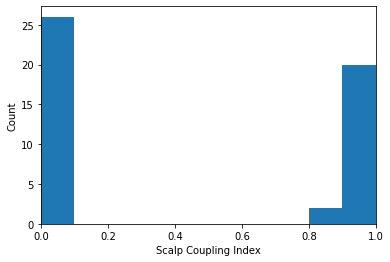

Effective window size : 204.800 (s)
Effective window size : 204.800 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
<ipython-input-82-648987cc120a>:36: UserWarning: Infinite value in PSD for channels S1_D8 hbo, S1_D14 hbo, S2_D2 hbo, S2_D3 hbo, S2_D9 hbo, S2_D11 hbo, S3_D4 hbo, S3_D5 hbo, S3_D9 hbo, S3_D10 hbo, S3_D12 hbo, S4_D7 hbo, S6_D10 hbo.
These channels might be dead.
  fig = raw_haemo.plot_psd(average=True)
<ipython-input-82-648987cc120a>:36: UserWarning: Infinite value in PSD for channels S1_D8 hbr, S1_D14 hbr, S2_D2 hbr, S2_D3 hbr, S2_D9 hbr, S2_D11 hbr, S3_D4 hbr, S3_D5 hbr, S3_D9 hbr, S3_D10 hbr, S3_D12 hbr, S4_D7 hbr, S6_D10 hbr.
The

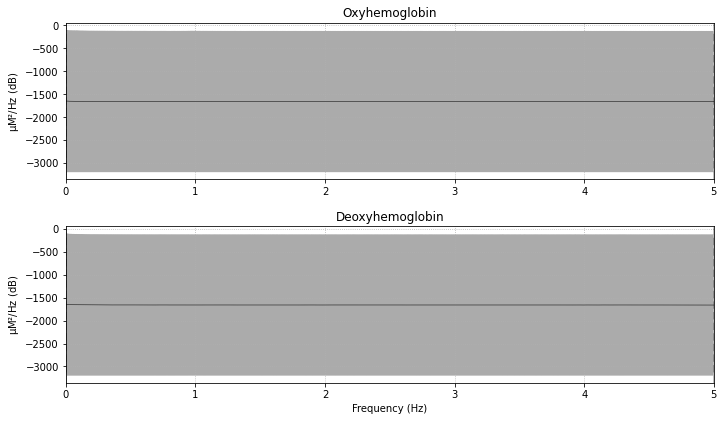

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1651 samples (165.100 sec)

Effective window size : 204.800 (s)
Effective window size : 204.800 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
<ipython-input-82-648987cc120a>:41: UserWarning: Infinite value in 

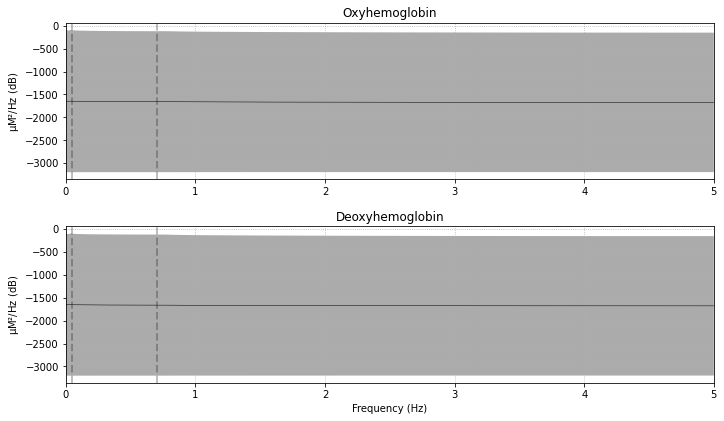

<Info | 9 non-empty values
 bads: []
 ch_names: S1_D1 hbo, S1_D1 hbr, S1_D8 hbo, S1_D8 hbr, S1_D14 hbo, S1_D14 ...
 chs: 24 Oxyhemoglobin, 24 Deoxyhemoglobin
 custom_ref_applied: False
 dig: 51 items (3 Cardinal, 48 EEG)
 highpass: 0.1 Hz
 lowpass: 0.7 Hz
 meas_date: 2021-12-09 10:12:50 UTC
 nchan: 48
 projs: []
 sfreq: 10.0 Hz
 subject_info: 1 item (dict)
>


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


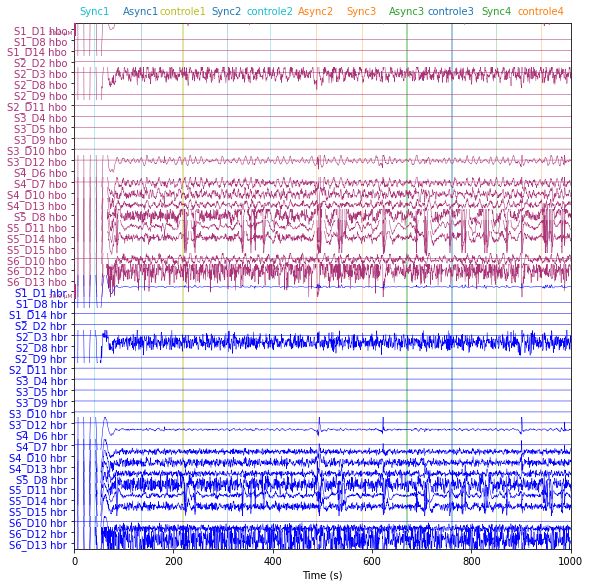

Used Annotations descriptions: ['Async1', 'Async2', 'Async3', 'Async4', 'Async5', 'Async6', 'Async7', 'Async8', 'Sync1', 'Sync2', 'Sync3', 'Sync4', 'Sync5', 'Sync6', 'Sync7', 'Sync8', 'controle1', 'controle2', 'controle3', 'controle4', 'controle5', 'controle6', 'controle7', 'controle8']
Not setting metadata
24 matching events found
Setting baseline interval to [-5.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 24 events and 201 original time points ...
0 bad epochs dropped


<ipython-input-82-648987cc120a>:68: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  sfreq=raw_haemo.info['sfreq'])


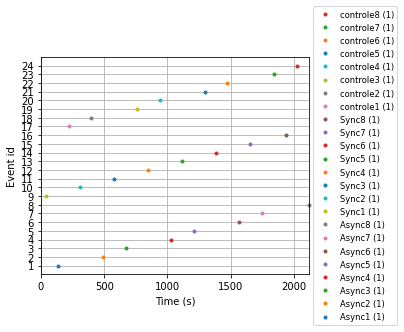

*
* /content/snirf/28_run2.snirf Sync1 X controle1
*----------------------------------------------------------------------
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


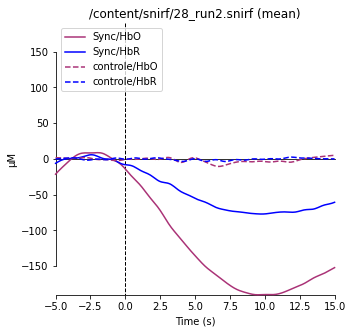

*
* /content/snirf/28_run2.snirf Async1 X controle1
*----------------------------------------------------------------------
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


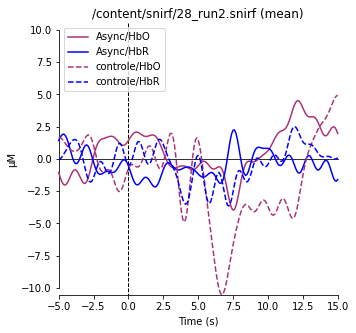

*
* /content/snirf/28_run2.snirf Sync2 X controle2
*----------------------------------------------------------------------
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


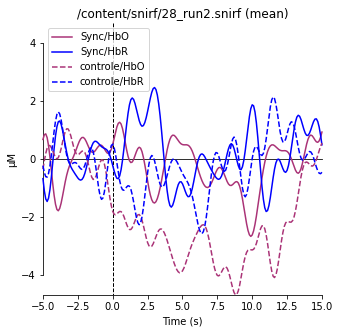

*
* /content/snirf/28_run2.snirf Async2 X controle2
*----------------------------------------------------------------------
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


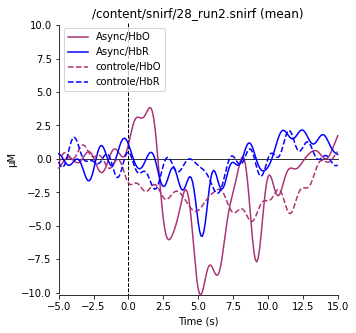

*
* /content/snirf/28_run2.snirf Sync3 X controle3
*----------------------------------------------------------------------
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


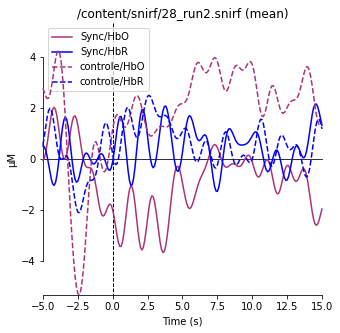

*
* /content/snirf/28_run2.snirf Async3 X controle3
*----------------------------------------------------------------------
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


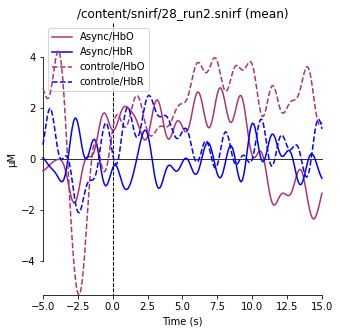

*
* /content/snirf/28_run2.snirf Sync4 X controle4
*----------------------------------------------------------------------
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


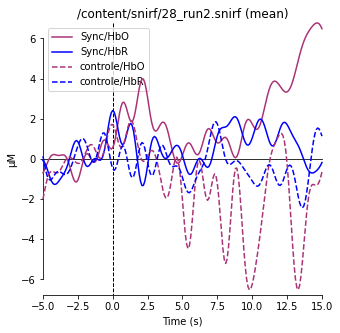

*
* /content/snirf/28_run2.snirf Async4 X controle4
*----------------------------------------------------------------------
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


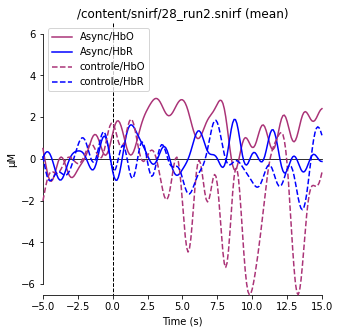

*
* /content/snirf/28_run2.snirf Sync5 X controle5
*----------------------------------------------------------------------
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


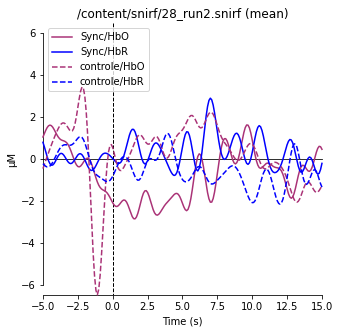

*
* /content/snirf/28_run2.snirf Async5 X controle5
*----------------------------------------------------------------------
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


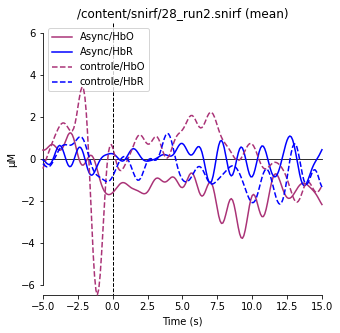

*
* /content/snirf/28_run2.snirf Sync6 X controle6
*----------------------------------------------------------------------
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


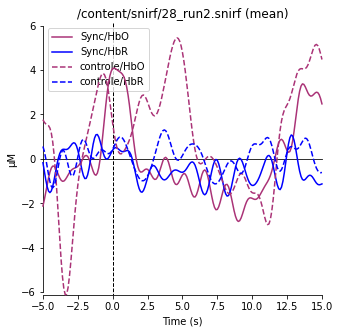

*
* /content/snirf/28_run2.snirf Async6 X controle6
*----------------------------------------------------------------------
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


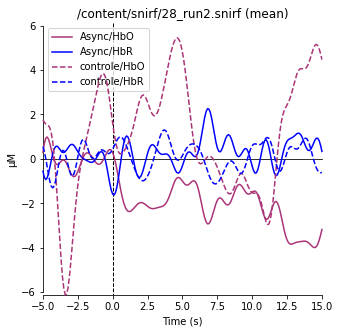

*
* /content/snirf/28_run2.snirf Sync7 X controle7
*----------------------------------------------------------------------
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


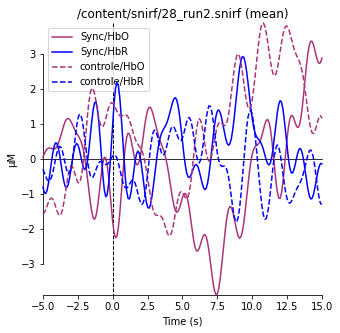

*
* /content/snirf/28_run2.snirf Async7 X controle7
*----------------------------------------------------------------------
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


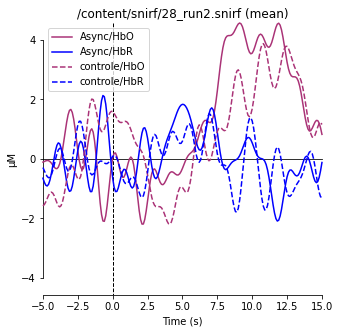

*
* /content/snirf/28_run2.snirf Sync8 X controle8
*----------------------------------------------------------------------
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


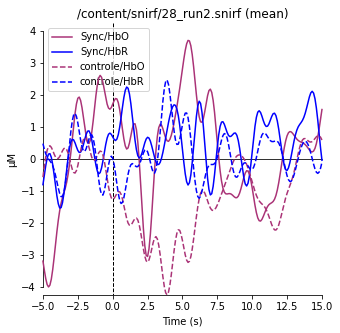

*
* /content/snirf/28_run2.snirf Async8 X controle8
*----------------------------------------------------------------------
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


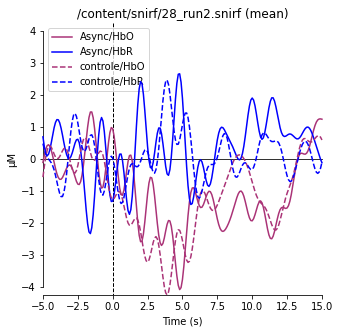

In [82]:
from mne.io import read_raw_nirx
from mne.preprocessing.nirs import (optical_density, beer_lambert_law,
                                    temporal_derivative_distribution_repair)
import mne
import pickle

threshold = 0.60 # FOR bad_list... se você tiver uma trocar!

if condicao == 1:
  # entries_sample = [ entries[4] ]
  entries_sample = [ '25_run1.snirf' ]
else:
  # entries_sample = [ entries[1] ]
  entries_sample = [ '28_run2.snirf' ]

print(entries_sample)

sci_df_exists = False
sci_df = pd.DataFrame()

for fname in entries_sample:
  raw_intensity = mne.io.read_raw_snirf(path_out + fname, verbose=True)
  raw_intensity.load_data()
  raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)
  sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od)
  
  fig, ax = plt.subplots()
  ax.hist(sci)
  ax.set(xlabel='Scalp Coupling Index', ylabel='Count', xlim=[0, 1])
  plt.show()
  
  # raw_od.info['bads'] = list(compress(raw_od.ch_names, sci < threshold))
  # raw_od.info['bads'] =  bad_list
  raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od)

  fig = raw_haemo.plot_psd(average=True)
  fig.suptitle('Before filtering', weight='bold', size='x-large')
  fig.subplots_adjust(top=0.88)
  raw_haemo = raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2,
                              l_trans_bandwidth=0.02)
  fig = raw_haemo.plot_psd(average=True)
  fig.suptitle('After filtering', weight='bold', size='x-large')
  fig.subplots_adjust(top=0.88)
  plt.show()

  print(raw_haemo.info)

  raw_haemo.plot(n_channels=48, duration=1000, show_scrollbars=False)
  plt.show()

  events, event_dict = mne.events_from_annotations(raw_haemo)

  # events, _ = mne.events_from_annotations(raw_haemo)
  # event_dict = {'Async': 2, 'Sync': 3, 'controle': 4}

  reject_criteria = dict(hbo=80e-6)
  tmin, tmax = -5, 15

  epochs = mne.Epochs(raw_haemo, events, event_id=event_dict,
                      tmin=tmin, tmax=tmax,
  #                    reject=reject_criteria, reject_by_annotation=True,
                      proj=True, baseline=(None, 0), preload=True,
                      detrend=None, verbose=True,
                      event_repeated='merge') # ADICIONADO Allowed values are 'error', 'drop', and 'merge'
  # epochs.plot_drop_log()

  fig = mne.viz.plot_events(events, event_id=event_dict,
                          sfreq=raw_haemo.info['sfreq'])
  fig.subplots_adjust(right=0.7)  # make room for the legend

  for i in range(8):
    n = str(i+1)
    plt_hemo(raw_haemo=raw_haemo, e1='Sync'+n, c1='controle'+n, e2='Async'+n, c2='controle'+n)


# Copy files para diretório `/snirf0` no diretório original




In [83]:
path_in

'/content/drive/MyDrive/Cond 2/snirf/'

In [84]:
path_out

'/content/snirf/'

In [85]:
if not os.path.exists(path_in + 'snirf0/'):
  os.mkdir(path_in + 'snirf0/')
  print("Directory " , path_in + 'snirf0/' ,  "was created")
else:    
  print("Warning: directory " , path_in + 'snirf0/' ,  " already exists")

entries = os.listdir(path_out)
out = path_in + 'snirf0/'

for f in entries:
  os.system('cp ' + path_out + f + ' ' + "'" + out + f  + "'")

Directory  /content/drive/MyDrive/Cond 2/snirf/snirf0/ was created
